In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from thermography_dataset import ThermDataset
%matplotlib inline

## Parameters 
Spec to Temp
Loss: 15
- batch size = 32
- epochs = 5000
- layers = lin2(60), lin3(45)
- lr = 0.01
- noise scale = 0.01
- test size = 30%

Temp to Spec
Loss: 0.0233

# Prepare Data

In [24]:
direction = 1
noise = 0.001

In [25]:
dataset = ThermDataset(fp='combined_data.xlsx', noise_scale=noise, tandem=1, direction=direction)

In [26]:
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [27]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size=32)

# Design Model 
(input size, output size, forward pass)

In [28]:
# forward model - remains as is and serves as a reference for the inverse model
# temperature to spectrum
class ForwardNet(nn.Module):
    def __init__(self, middle_size, io_size):
        super(ForwardNet, self).__init__()
        self.lin1 = nn.Linear(middle_size, 60)
        self.lin2 = nn.Linear(60, 45)
        self.lin3 = nn.Linear(45, 30)
        self.lin_fin = nn.Linear(30, io_size)


    def forward(self, X_batch):
        output = F.leaky_relu(self.lin1(X_batch))
        output = F.leaky_relu(self.lin2(output))
        output = F.leaky_relu(self.lin3(output))
        output = self.lin_fin(output)
        return output

In [29]:
# inverse model -  incorporates the bottleneck layer implementation to learn the inverse mapping from spectrum to temperature
# spectrum to temeperature

# still fixing 
# attempt 1
'''class InverseNet(nn.Module):
    def __init__(self, io_size, middle_size, bottleneck_size):
        super(InverseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(io_size, 30),
            nn.ReLU(),
            nn.Linear(30, bottleneck_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 30),
            nn.ReLU(),
            nn.Linear(30, io_size),
            nn.ReLU()
        )

    def forward(self, X_batch):
        encoded = self.encoder(X_batch)
        decoded = self.decoder(encoded)
        return decoded
    
# define variables
input_size = 66  # Spectrum size
output_size = 11  # Temperature size
middle_size = 30  # Size of intermediate layer in the forward model
bottleneck_size = 5  # Size of the bottleneck layer

inverse_model = InverseNet(input_size, middle_size, bottleneck_size) '''

# attempt 2
class InverseNet(nn.Module):
    def __init__(self, forward_model, input_size, bottleneck_size, output_size):
        super(InverseNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 60),
            nn.ReLU(),
            nn.Linear(60, 45),
            nn.ReLU(),
            nn.Linear(45, 30),
            nn.ReLU(),
            nn.Linear(30, bottleneck_size),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_size, 30),
            nn.ReLU(),
            nn.Linear(30, 45),
            nn.ReLU(),
            nn.Linear(45, 60),
            nn.ReLU(),
            nn.Linear(60, output_size),
            nn.ReLU()
        )
        self.forward_model = forward_model

    def forward(self, X_batch):
        encoded = self.encoder(X_batch)
        decoded = self.decoder(encoded)
        return decoded

    def forward_with_forward_model(self, X_batch):
        encoded = self.encoder(X_batch)
        decoded = self.decoder(encoded)
        forward_output = self.forward_model(decoded)
        return decoded, forward_output

# define variables
input_size = 66  # Spectrum size
bottleneck_size = 5  # Bottleneck size
output_size = 11  # Temperature size
middle_size = 30  # Size of intermediate layer in the forward model

forward_model = ForwardNet(middle_size, output_size)
inverse_model = InverseNet(forward_model, input_size, bottleneck_size, output_size)

In [30]:
class TandemNet(nn.Module):
    def __init__(self, forward_model, inverse_model):
        super(TandemNet, self).__init__()
        self.forward_model = forward_model
        self.inverse_model = inverse_model

    def forward(self, y):
        pred_temp = self.inverse_model(y)
        pred_spec = self.forward_model(pred_temp)
        return pred_temp, pred_spec

In [31]:
# ?
n_samples = len(train_dataset)
_, middle_size = dataset.x.shape
_, io_size = dataset.y.shape

# define variables for each model
forward_model = ForwardNet(middle_size, io_size)
inverse_model = InverseNet(forward_model, input_size, bottleneck_size, output_size)
tandem_net = TandemNet(forward_model, inverse_model)

# Construct Loss and Optimizer

In [32]:
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer_forward = torch.optim.Rprop(forward_model.parameters(), lr=learning_rate)
optimizer_tandem = torch.optim.Rprop(inverse_model.parameters(), lr=learning_rate)

# Training Loop

In [33]:
# leave as is for bottleneck approach
def train_forward_model(forward_model, train_loader):

    forward_loss_list = []
    num_forward_epochs = 1000
    best_forward_loss = np.inf
    best_forward_epoch = 0

    for epoch in range(num_forward_epochs):
        for X_batch, y_batch in train_loader:
            # forward pass and loss
            y_pred = forward_model(X_batch)
            loss = criterion(y_pred, y_batch)

            # backward pass
            loss.backward()

            # update
            optimizer_forward.step()

            # empty gradients
            optimizer_forward.zero_grad()
        
        forward_loss_list.append(loss.item())
        
        if loss < best_forward_loss:
            best_forward_loss = loss
            best_forward_epoch = epoch+1

        if (epoch+1) % int(num_forward_epochs/10) == 0:
            print(f'forward epoch: {epoch+1}, forward loss = {loss}')

    print(f'\nbest forward loss: {best_forward_loss:.4f} in forward epoch: {best_forward_epoch}\n')
    return num_forward_epochs, forward_loss_list

In [34]:
def train_tandem_model(inverse_model, forward_model, train_loader):

    tandem_loss_list = []
    inverse_loss_list = []
    num_inverse_epochs = 1000
    best_inverse_loss = np.inf
    best_inverse_epoch = 0

    # trains the inverse model first, then the tandem——specify proprotion inverse
    percent_inverse = .65

    # using sum loss
    sum = False

    for epoch in range(num_inverse_epochs):
        # indicate what type of training is done
        if epoch % (num_inverse_epochs / 10) == 0:
            if epoch < (num_inverse_epochs * percent_inverse):
                print('inverse training')
            else:
                print('tandem training')

        for X_batch, y_batch in train_loader:
            # forward pass through both models
            X_pred = inverse_model(y_batch)
            y_pred = forward_model(X_pred)

            # calculate tandem loss (used for training)
            tandem_loss = criterion(y_pred, y_batch)

            # calculate the inverse loss (what we care about but not used for training)
            inverse_loss = criterion(X_pred, X_batch)

            # sum of the losses
            sum_loss = inverse_loss + tandem_loss

            if sum:
                sum_loss.backward()
            
            else:
                # for first half of epochs, train inverse network
                if epoch < (num_inverse_epochs * percent_inverse):
                    inverse_loss.backward()

                # for second half of epochs, train tandem network
                else:
                    tandem_loss.backward()

            # update
            optimizer_tandem.step()

            # empty gradients
            optimizer_tandem.zero_grad()
        
        tandem_loss_list.append(tandem_loss.item())
        inverse_loss_list.append(inverse_loss.item())
        
        if inverse_loss < best_inverse_loss:
            best_inverse_loss = inverse_loss
            best_inverse_epoch = epoch+1

        if (epoch+1) % int(num_inverse_epochs/10) == 0:
            print(f'tandem epoch: {epoch+1}, tandem loss = {tandem_loss:.4f}, *INVERSE LOSS* = {inverse_loss:.4f}')

    print(f'\n best inverse loss: {best_inverse_loss:.4f} in inverse epoch: {best_inverse_epoch}')
    return num_inverse_epochs, inverse_loss_list, tandem_loss_list

In [35]:
# first train the forward model
num_forward_epochs, forward_loss_list = train_forward_model(forward_model, train_loader)

# freeze forward layers
for param in forward_model.lin1.parameters():
    param.requires_grad = False

for param in forward_model.lin2.parameters():
    param.requires_grad = False

for param in forward_model.lin3.parameters():
    param.requires_grad = False

for param in forward_model.lin_fin.parameters():
    param.requires_grad = False

# train the tandem model
num_inverse_epochs, inverse_loss_list, tandem_loss_list = train_tandem_model(inverse_model, forward_model, train_loader)

forward epoch: 100, forward loss = 0.05500615015625954
forward epoch: 200, forward loss = 0.037771571427583694
forward epoch: 300, forward loss = 0.06125148758292198
forward epoch: 400, forward loss = 0.0348452553153038
forward epoch: 500, forward loss = 0.10854830592870712
forward epoch: 600, forward loss = 0.057337187230587006
forward epoch: 700, forward loss = 0.16169489920139313
forward epoch: 800, forward loss = 0.03452860191464424
forward epoch: 900, forward loss = 0.057147443294525146
forward epoch: 1000, forward loss = 0.07684065401554108

best forward loss: 0.0062 in forward epoch: 947

inverse training
tandem epoch: 100, tandem loss = 31.2749, *INVERSE LOSS* = 28876.1934
inverse training
tandem epoch: 200, tandem loss = 33.1219, *INVERSE LOSS* = 29444.8359
inverse training
tandem epoch: 300, tandem loss = 35.4389, *INVERSE LOSS* = 29308.5801
inverse training
tandem epoch: 400, tandem loss = 35.4848, *INVERSE LOSS* = 27792.0312
inverse training
tandem epoch: 500, tandem loss =

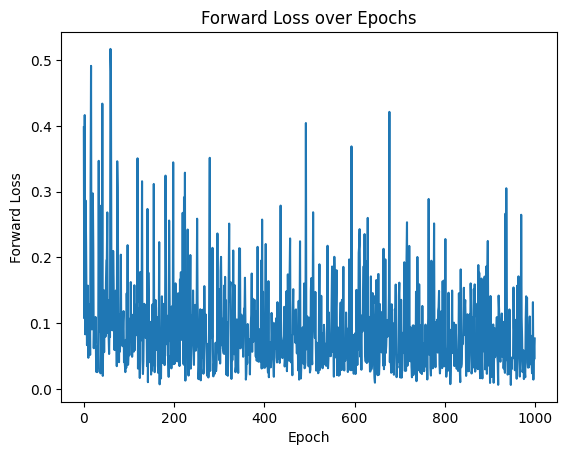

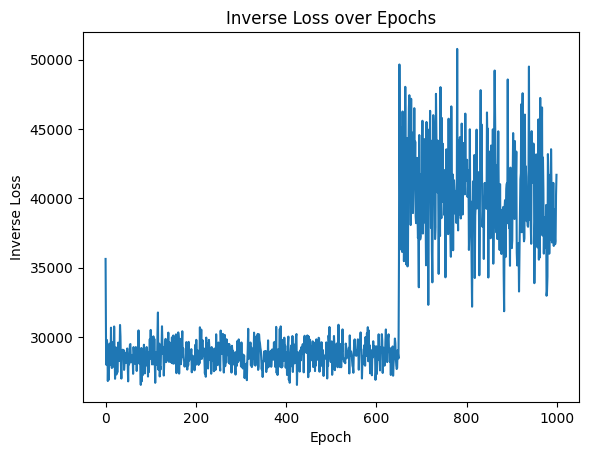

In [36]:
# plot forward loss
plt.plot(forward_loss_list)

plt.title("Forward Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Forward Loss")
plt.show()

# plot inverse loss
plt.plot(inverse_loss_list)

plt.title("Inverse Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Inverse Loss")
plt.show()



# Testing

In [37]:
import matplotlib.pyplot as plt

# to graph temperature error, set graph_temp to True
# to graph spectra error, set graph_temp to False
graph_temp = False

def plot_actual_vs_pred(pred, actual, index):
    actual_np = actual[index]
    pred_np = pred[index]


    plt.plot(actual_np, label='actual')
    plt.plot(pred_np, 'r+', label='predicted')

    if graph_temp:
        plt.title("Radiation Spectrum: Predicted vs Actual")
        plt.xlabel("Silica Layer")
        plt.ylabel("Temperature (K)")
    else:
        plt.title("Temperature Distribution: Predicted vs Actual")
        plt.xlabel("Wavelength Index")
        plt.ylabel("Intensity")

    plt.legend()
    plt.show()

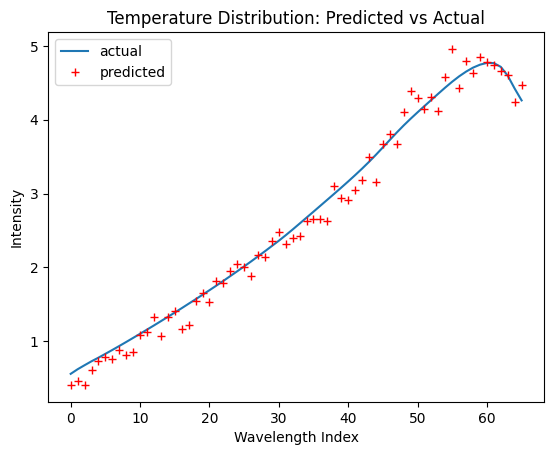

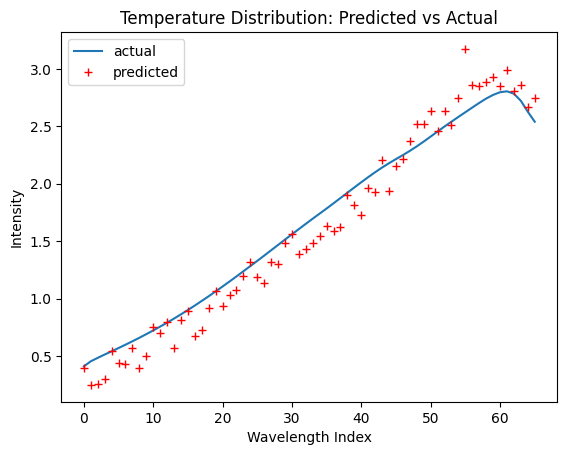

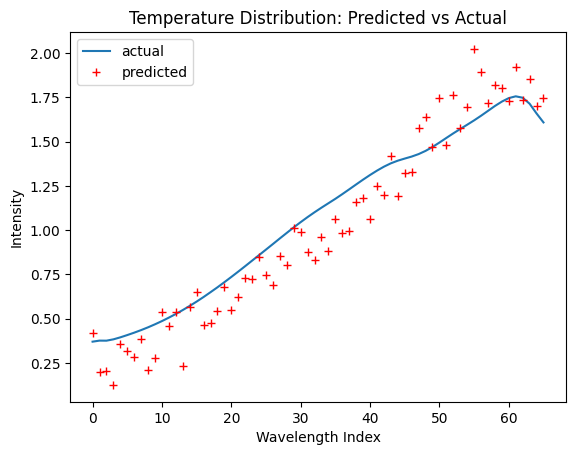

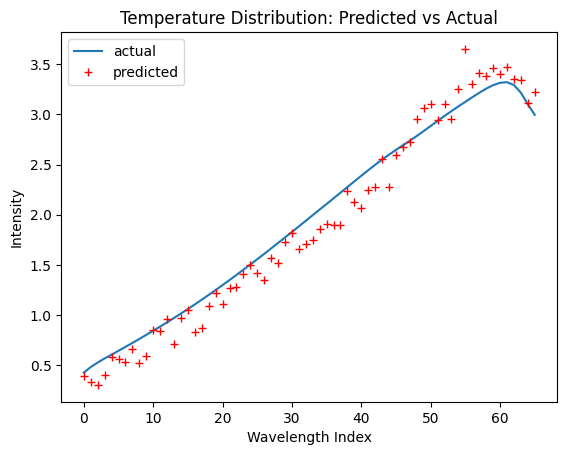

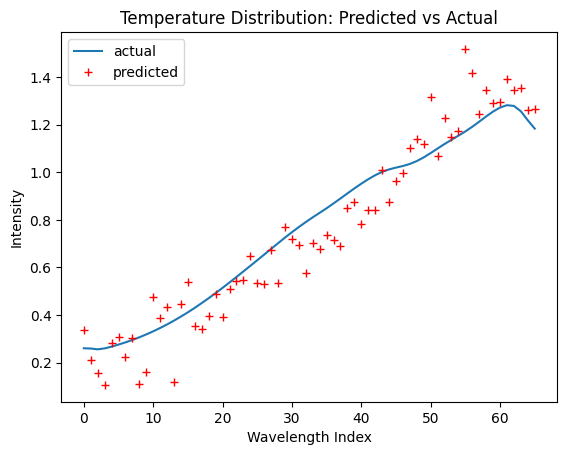

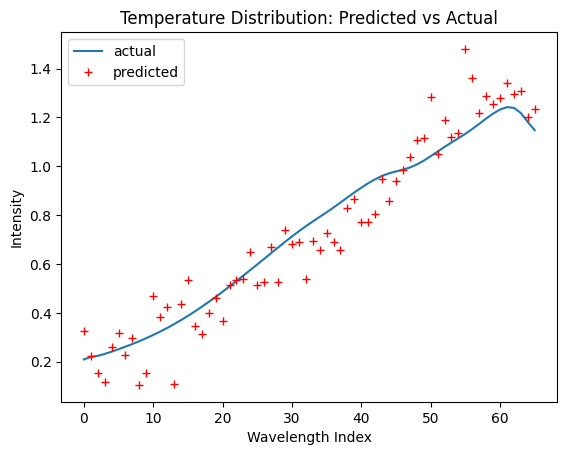

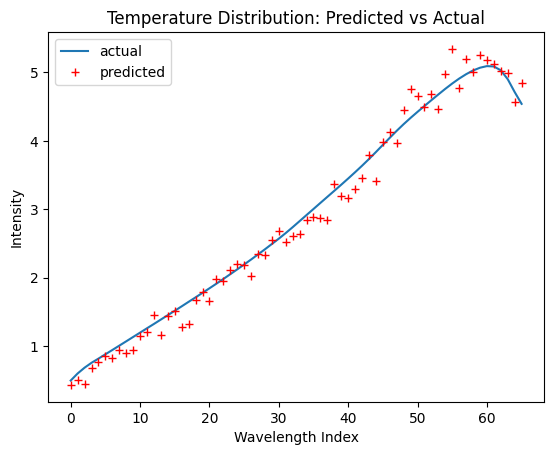

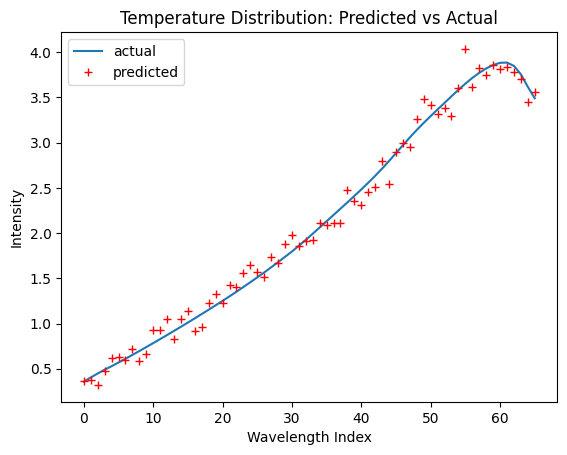

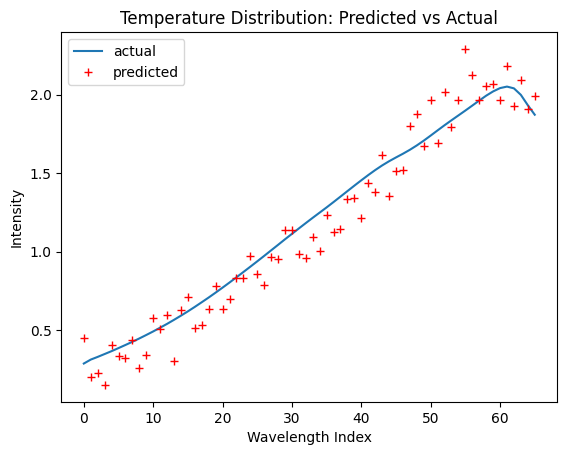

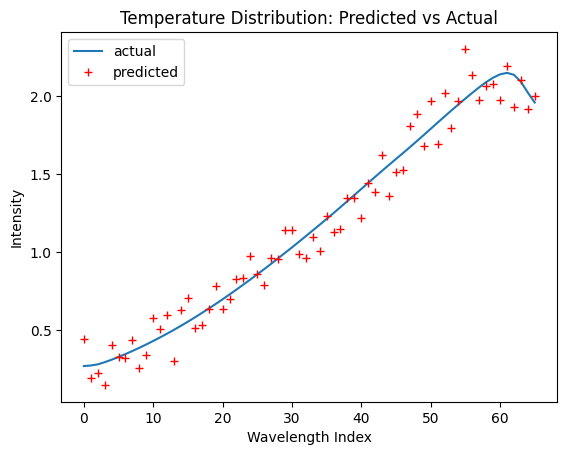

In [38]:
total_loss = 0
n_samples = 0
total_batches = len(test_loader)
current_batch = 0

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        actual_input = y_batch
        actual_middle = X_batch

        pred_middle = inverse_model(actual_input)
        inverse_test_loss = criterion(pred_middle, actual_middle)

        pred_output = forward_model(pred_middle)
        
        total_loss += inverse_test_loss.item() * len(X_batch)
        n_samples += len(X_batch)
        current_batch += 1
        
        if graph_temp:
            if current_batch % int(total_batches/10) == 0:
                plot_actual_vs_pred(pred_middle.numpy(), actual_middle.numpy(), 0) 
        else:
            if current_batch % int(total_batches/10) == 0:
                plot_actual_vs_pred(pred_output.numpy(), actual_input.numpy(), 0) 

# average_loss = total_loss/n_samples
# print(f"average loss: {average_loss}")